
# CSCI 6505: Machine Learning 
## Assignment 2 
##### Objective: Implement a basic neural net in numpy


---









#### Marked down: 1
### Part 1: A Feedforward Neural Network
a) __[3pts] Create the data set__. Choose from the following three options:
>__[1pt] Option 1__: Create and visualize a two-class data set consisting of two Gaussians, similarly scaled as the ones in the bottom left data set in PlayGround.

> __[2pts] Option 2__: Create and visualize both:
        i. a two-class data set as in Option 1
        ii. a two-class data set of concentric circles, as in the upper left data set in PlayGround.

> __[3pts] Option 3__: Create and visualize both Gaussian clusters and concentric circles, but this time allow the  user to specify how many different clusters/circles the distribution includes. For example, if (numClasses==3) then that will generate three Gaussians, or three concentric circles, corresponding to three distinct classes. The sample function below has been modified accordingly, with a default value, so that if you are only able to handle two classes, it will still be called the same way.<br>

b) __[1pt] Add noise__: Add an option that allows you to add label noise with a given probability.


---




In [30]:
# If you get error running this cell, 
# you might need to install tqdm (a progress bar library) by uncommenting line below and re-run runtime 

# !pip install tqdm --upgrade tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
from random import choice
import time
import collections as c
from tqdm.notebook import tqdm
from numpy import pi
from tqdm.notebook import tqdm
import copy

In [31]:
def add_noise(noise, numExamples, numClasses, scatter_plot):
    noisy_examples=int(noise*numExamples*numClasses)
    np.random.shuffle(scatter_plot)
    for i in range (0, noisy_examples):
        label=scatter_plot[i,-1]
        label_random=choice([i for i in range(0,numClasses) if i not in [label]])
        scatter_plot[i,-1]=label_random        
    return scatter_plot

In [32]:
def plotIt(plot):
    plt.scatter(plot[:,0], plot[:,1], c=plot[:,2])

In [33]:
def plot_contour(X, W1, W2, b1, b2 ,act, numOutput=1):
    plt.figure(figsize=(7, 7))
    cmap = plt.cm.Spectral_r #our color map for contours
    X, y = X[:,0:2],X[:,2:] #getting data and labels seperated
    X_min, X_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    X1 = np.around(np.arange(X_min,X_max,h),2)
    X2 = np.around(np.arange(y_min,y_max,h),2)
    xx, yy = np.meshgrid(X1,X2)
    Z = np.around(predict(np.c_[xx.ravel(),yy.ravel()], W1, W2, b1, b2, act, numOutput=numOutput))
    Z = Z.reshape(xx.shape)
    plt.contourf(X1,X2,Z)
    plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1), cmap=plt.cm.Spectral)
    plt.show()


In [34]:
def plotLoss(trainLoss, testLoss):
    xTrain=list(range(1,len(trainLoss)+1))
    xTest=list(range(1,len(testLoss)+1))
    plt.plot(xTrain, trainLoss, label='Train Loss')
    plt.plot(xTest, testLoss, label='test Loss')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [35]:
def precision(predicted_labels, true_labels):
    predicted_labels = predicted_labels.flatten()
    true_labels = true_labels.flatten()
    x=np.bincount(np.equal(true_labels,predicted_labels).astype(int))# bincount counts the number of occurences of each element
    tp=x[1] #true positives 
    fp=x[0] # false positives
    score=tp/(tp+fp) #precision = (true positives / (true positives +false positives))
    return round(score*100,2)

In [36]:
def generateData (numExamples, distributionShape, noise=0.05, numClasses = 2, numOutputs=1):
    numExamples = round(numExamples/numClasses)
    rings = None
    plots = None
    t = np.linspace(0,2*np.pi,numExamples)
    x = np.cos(t)
    y = np.sin(t)
    plt.figure(figsize=(7,7))

    if distributionShape=='c':
        for i in range(0, numClasses):
            if i==0:
                xy=np.column_stack((i+1 * x, i+1 * y))+np.random.normal(scale=1.0/2,size=(numExamples,2))
                label=np.ones((numExamples,1))
                xy_labelled=np.column_stack((xy,label*i))
                rings=xy_labelled
            else:
                xy=np.column_stack((i*5 * x, i*5 * y))+np.random.uniform(low=-1, high=1, size=(numExamples,2))
                label=np.ones((numExamples,1))
                xy_labelled=np.column_stack((xy,label*i))
                rings=np.append(rings,xy_labelled, axis=0)        
        if noise>0:
            rings=add_noise(noise, numExamples, numClasses, rings)
            plotIt(rings)
            return rings
        else:
            np.random.shuffle(rings)
            plotIt(rings)
            return rings            
    elif distributionShape=='g':
        r=1
        for i in range (0, numClasses):
            xy=np.column_stack((r * x+(i*4) ,r * y+(i*4)))+np.random.normal(scale=1.0/2,size=(numExamples,2))
            label=np.ones((numExamples,1))
            xy_labelled=np.column_stack((xy,label*i))
            if i==0:
                plots=xy_labelled
            else:
                plots=np.append(plots,xy_labelled, axis=0)
        np.random.shuffle(plots)
        if noise>0:
            plots=add_noise(noise, numExamples, numClasses, plots)
            plotIt(plots)
            return plots
        else:
            np.random.shuffle(plots)
            plotIt(plots)
            return plots
    else:
        print("Please enter distribution shape as g (Gaussian) or c (Circular)!")
    



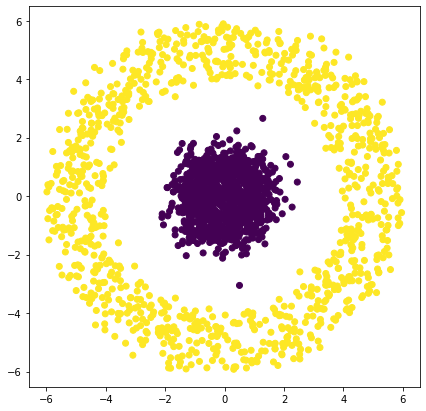

In [37]:
X=generateData(2000, 'c', 0, 2)
del X

#### Marked down: 2
### Different activation functions

In [38]:
"""Dfferent activation fucntons"""
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def reLU(z): 
    return np.maximum(0.0,z)

def linear(z, m, c):
    return (m*z)+c

def softmax(z):
    exps = np.exp(z-np.max(z, axis=0, keepdims=True))
    output = exps/np.sum(exps, axis=0, keepdims=True)
    return output    

####  marked down: 3
epsilon = 1e-12 is mathematical rep of 1 x $10^{-12}$

In [29]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

# uncomment lines below to see example use of cross entropy function

# predictions = np.array([[0.25,0.25,0.25,0.25],
#                         [0.01,0.01,0.01,0.96]])
# targets = np.array([[0,0,0,1],
#                    [0,0,0,1]])
# ans = 0.71355817782  #Correct answer
# x = cross_entropy(predictions, targets)
# print(np.isclose(x,ans))

In [39]:
#This function serves the purpose of splitting the output (label) column into multis for softmax layer 
def softmaxColGen(labels, numClasses):
    if numClasses>=2:
        labels_set = np.unique(labels)
        flag=0
        for label in labels_set:
            col=(labels==label).astype('int')
            if flag==0:
                X_multiLabelCols = col
            else:
                X_multiLabelCols = np.column_stack((X_multiLabelCols,col))
            flag+=1
        return X_multiLabelCols

In [40]:
#This collects the columns back and merges them
def softmaxColMerge(dataset, numClasses):
    if numClasses>=2:
        merge=np.argmax(dataset, axis=0)
        return merge

#### Marked down: 2
c) __[7pts] Train a small feedforward neural network__:

In [41]:
def train(X, numInput, numHiddenUnits, numOutput, activationType, numIter):
    dataset = X
    X = X[:, :numInput]
    y = dataset[:, numInput:] #slicing array to get labels
    alpha = 0.0001 #learning rate 
    print("---------------------- Initializing Training ------------------------\n")  
    if(numOutput==1):
        print("Using Sigmoid for output layer and Mean Squared Error loss")
    else:
        print("Using SoftMax for output layer and Cross Entropy loss")
    if numOutput > 1:
        y = softmaxColGen(y, numClasses=numOutput) #Generating cols for Softmax layer
    t = y.T
    X = X.T
    #--------------Weights Initialization--------------
    W1 = np.random.random((numHiddenUnits, numInput))
    W2 = np.random.random((numOutput, numHiddenUnits))
    b1 = 1
    b2 = 1
    #--------------------------------------------------   
    if activationType == 'sigmoid':
        for i in tqdm(range(numIter),desc="[Training with Sigmoid]" ):
            # ----------------------- Forward Pass ------------------------
            Z1 = np.dot(W1, X) + b1
            A1 = sigmoid(Z1)
            Z2 = np.dot(W2, A1) + b2
            if numOutput == 1:
                A2 = sigmoid(Z2)
            else:
                A2 = softmax(Z2)
            # ----------------------- Backward Pass -----------------------
            if numOutput == 1:
                dA2 = A2 - t
                dZ2 = dA2 * A2 * (1-A2) #sigmoid
            else:
                dZ2 = A2 - t #softmax
            dW2 = np.dot(dZ2, A1.T)
            db2 = np.sum(dZ2, axis=1, keepdims=True)
            dA1 = np.dot(W2.T, dZ2)
            dZ1 = dA1 * A1 * (1-A1)
            dW1 = np.dot(dZ1, X.T)
            db1 = np.sum(dZ1, axis=1, keepdims=True)
            # ---------------------- Updating weights ---------------------
            W1 -= alpha * dW1
            W2 -= alpha * dW2
            b1 -= alpha * db1
            b2 -= alpha * db2   
    elif activationType == 'reLU':
        for i in tqdm(range(numIter), desc="[Training with ReLU]"):
            # ----------------------- Forward Pass ------------------------
            Z1 = np.dot(W1, X) + b1
            A1 = reLU(Z1)
            Z2 = np.dot(W2, A1) + b2
            if numOutput == 1:
                A2 = sigmoid(Z2)
            else:
                A2 = softmax(Z2)
            # ----------------------- Forward Pass ------------------------
            if numOutput == 1:
                dA2 = A2 - t
                dZ2 = dA2 * A2 * (1 - A2)
            else:
                dZ2 = A2 - t
            dW2 = np.dot(dZ2, A1.T)
            db2 = np.sum(dZ2, axis=1, keepdims=True)
            dA1 = np.dot(W2.T, dZ2)
            dZ1 = dA1 * ((Z1 > 0) + 0)
            dW1 = np.dot(dZ1, X.T)
            db1 = np.sum(dZ1, axis=1, keepdims=True)
            # ---------------------- Updating weights ---------------------
            W1 -= alpha * dW1
            W2 -= alpha * dW2
            b1 -= alpha * db1
            b2 -= alpha * db2   
    elif activationType == 'linear':
        m = 0.01 # slope for our line m(x)+c
        c = 0.03 # y-intercept of our line
        for i in tqdm(range(numIter),desc="[Training with Linear]"):
            # ----------------------- Forward Pass ------------------------
            Z1 = np.dot(W1, X) + b1
            A1 = linear(Z1, m, c)
            Z2 = np.dot(W2, A1) + b2
            if numOutput == 1:
                A2 = sigmoid(Z2)
            else:
                A2 = softmax(Z2)
            # ---------------------- Backward Pass ------------------------
            if numOutput == 1:
                dA2 = A2 - t
                dZ2 = dA2 * A2 * (1 - A2)
            else:
                dZ2 = A2 - t
            dW2 = np.dot(dZ2, A1.T)
            db2 = np.sum(dZ2, axis=1, keepdims=True)
            dA1 = np.dot(W2.T, dZ2)
            dZ1 = dA1 * m
            dW1 = np.dot(dZ1, X.T)
            db1 = np.sum(dZ1, axis=1, keepdims=True)
            # ---------------------- Updating weights ---------------------
            W1 -= alpha * dW1
            W2 -= alpha * dW2
            b1 -= alpha * db1
            b2 -= alpha * db2

    return W1, W2, b1, b2  # updated parameters

In [14]:
def predict(x, W1, W2, b1, b2, activationType='sigmoid', numOutput=1, verbosity=0):
    x=x.T
    if activationType=='sigmoid':
        if (verbosity):
            print("Activation: Sigmoid")
            print("True labels: {}".format(x.shape))
            print("Weights: W1{} W2{}".format(W1.shape,W2.shape))
            print("Biases: b1{} b2{}".format(b1.shape,b2.shape))
            print("Number of outputs: {}".format(numOutput))
        Z1 = np.dot(W1,x)+b1
        A1 = sigmoid(Z1)
        Z2 = np.dot(W2,A1)+b2
        if numOutput==1:
            A2 = sigmoid(Z2)
        else:
            A2 = softmax(Z2)
            A2 = softmaxColMerge(np.around(A2),numOutput)
        return np.around(A2) #rounding output
    elif activationType=='reLU':
        if (verbosity):
            print("Activation: reLU")
            print("True labels: {}".format(x.shape))
            print("Weights: W1{} W2{}".format(W1.shape,W2.shape))
            print("Number of outputs: {}".format(numOutput))
        Z1 = np.dot(W1,x)+b1
        A1 = reLU(Z1)
        Z2 = np.dot(W2,A1)+b2
        if numOutput==1:
            A2 = sigmoid(Z2)
        else:
            A2 = softmax(Z2)
            A2 = softmaxColMerge(np.around(A2),numOutput)
        return np.around(A2)
    elif activationType=='linear':
        if (verbosity):
            print("Activation: Linear")
            print("True labels: {}".format(x.shape))
            print("Weights: W1{} W2{}".format(W1.shape,W2.shape))
            print("Biases: b1{} b2{}".format(b1.shape,b2.shape))
            print("Number of outputs: {}".format(numOutput))
        m=0.01
        c=0.03
        Z1 = np.dot(W1,x)+b1
        A1 = linear(Z1, m, c)
        Z2 = np.dot(W2,A1)+b2
        if numOutput==1:
            A2 = sigmoid(Z2)
        else:
            A2 = softmax(Z2)
            A2 = softmaxColMerge(np.around(A2),numOutput)
        return np.around(A2)

Distribution Shape: g
Activation Type: sigmoid
Hidden Units: 5
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: Sigmoid
True labels: (2, 199)
Weights: W1(5, 2) W2(3, 5)
Biases: b1(5, 1) b2(3, 1)
Number of outputs: 3
Score: 100.0


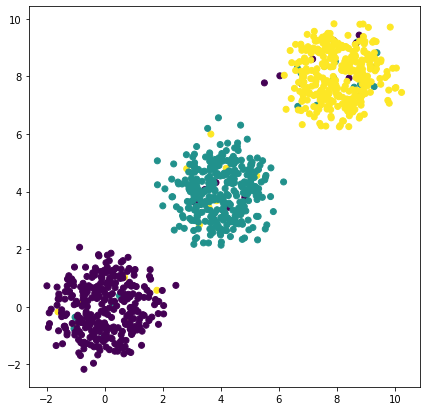

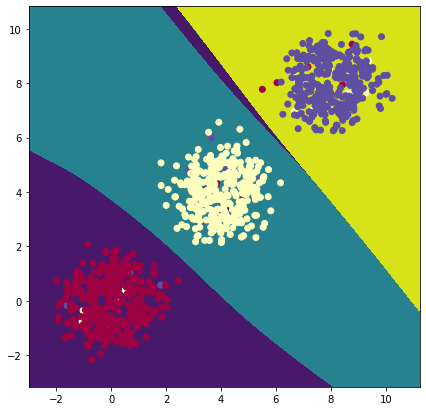

Hidden Units: 6
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: Sigmoid
True labels: (2, 199)
Weights: W1(6, 2) W2(3, 6)
Biases: b1(6, 1) b2(3, 1)
Number of outputs: 3
Score: 100.0


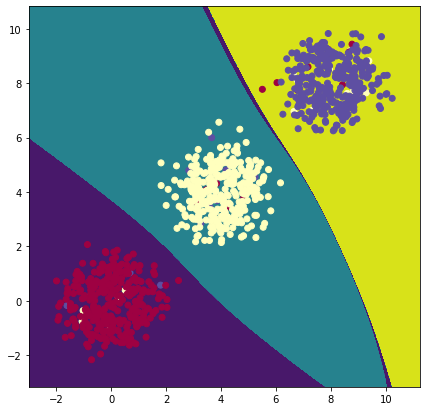

Activation Type: reLU
Hidden Units: 5
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: reLU
True labels: (2, 199)
Weights: W1(5, 2) W2(3, 5)
Number of outputs: 3
Score: 99.5


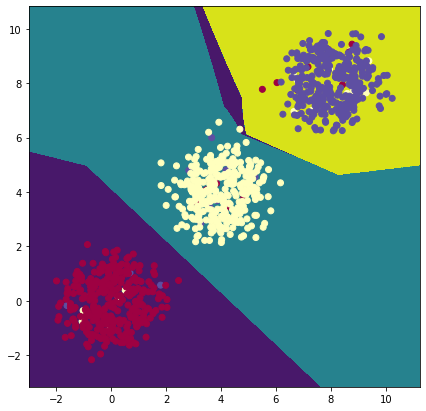

Hidden Units: 6
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: reLU
True labels: (2, 199)
Weights: W1(6, 2) W2(3, 6)
Number of outputs: 3
Score: 100.0


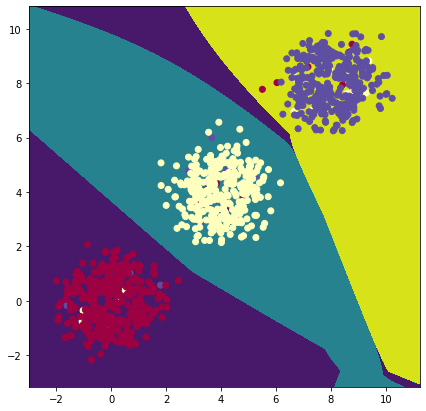

Activation Type: linear
Hidden Units: 5
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: Linear
True labels: (2, 199)
Weights: W1(5, 2) W2(3, 5)
Biases: b1(5, 1) b2(3, 1)
Number of outputs: 3
Score: 100.0


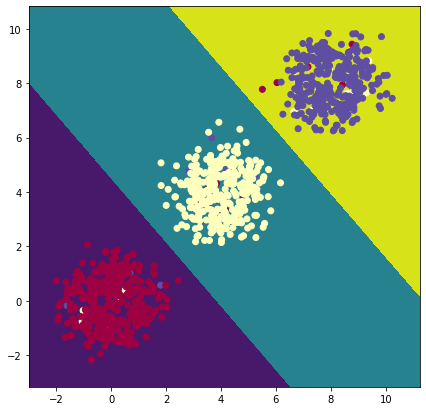

Hidden Units: 6
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: Linear
True labels: (2, 199)
Weights: W1(6, 2) W2(3, 6)
Biases: b1(6, 1) b2(3, 1)
Number of outputs: 3
Score: 100.0


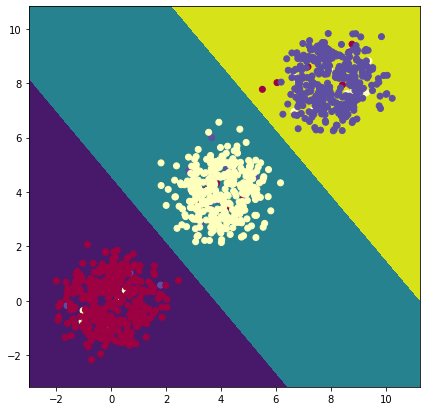

Distribution Shape: c
Activation Type: sigmoid
Hidden Units: 5
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: Sigmoid
True labels: (2, 199)
Weights: W1(5, 2) W2(3, 5)
Biases: b1(5, 1) b2(3, 1)
Number of outputs: 3
Score: 96.98


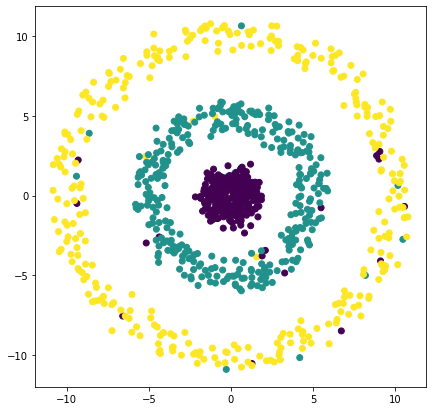

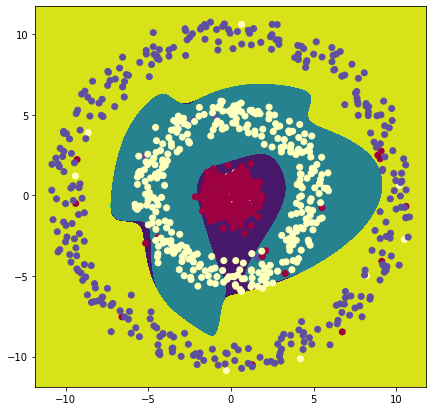

Hidden Units: 6
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: Sigmoid
True labels: (2, 199)
Weights: W1(6, 2) W2(3, 6)
Biases: b1(6, 1) b2(3, 1)
Number of outputs: 3
Score: 96.98


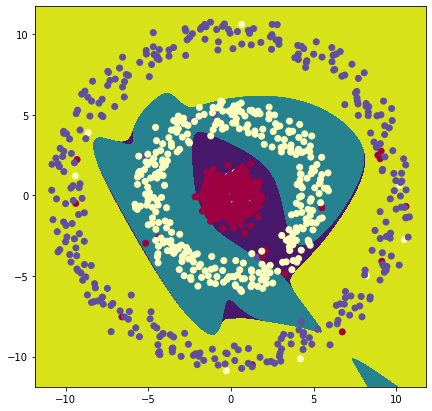

Activation Type: reLU
Hidden Units: 5
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: reLU
True labels: (2, 199)
Weights: W1(5, 2) W2(3, 5)
Number of outputs: 3
Score: 98.99


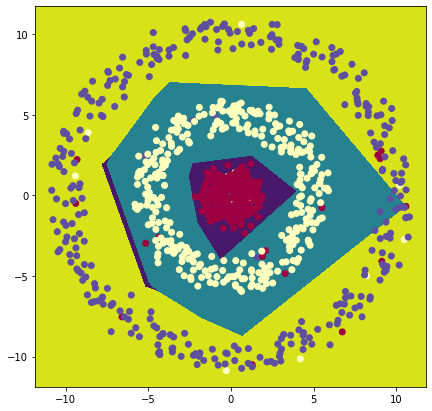

Hidden Units: 6
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: reLU
True labels: (2, 199)
Weights: W1(6, 2) W2(3, 6)
Number of outputs: 3
Score: 90.95


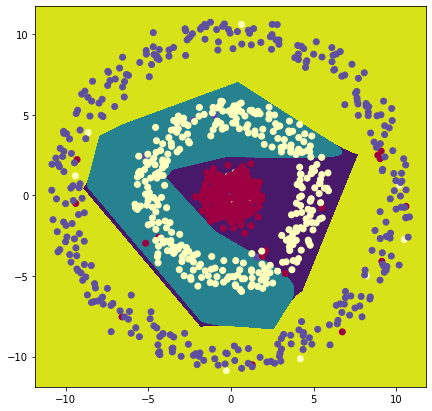

Activation Type: linear
Hidden Units: 5
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: Linear
True labels: (2, 199)
Weights: W1(5, 2) W2(3, 5)
Biases: b1(5, 1) b2(3, 1)
Number of outputs: 3
Score: 29.15


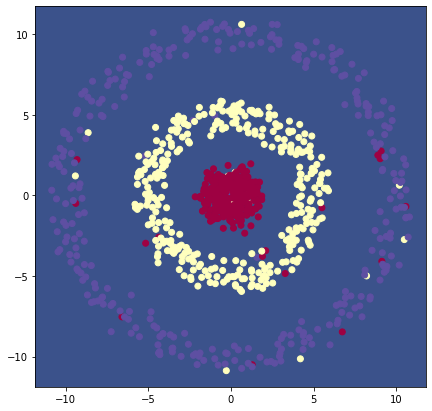

Hidden Units: 6
---------------------- Initializing Training ------------------------

Using SoftMax for output layer and Cross Entropy loss



---------------------- Training Over 😀------------------------
---------------------- Predicting 😎------------------------
Activation: Linear
True labels: (2, 199)
Weights: W1(6, 2) W2(3, 6)
Biases: b1(6, 1) b2(3, 1)
Number of outputs: 3
Score: 29.15


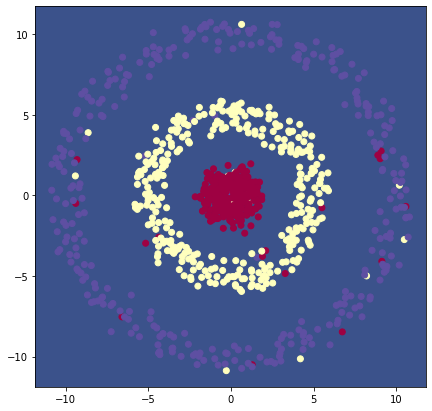

In [15]:
actFuncs = ['sigmoid', 'reLU', 'linear']#you can tweak this list to tailor outputs to your needs 
hUnits = [5,6] # you can tweak this list to tailor outputs to your needs 
dShapes = ['g', 'c'] # you can tweak this list to tailor outputs to your needs 
for shape in dShapes:
    print("Distribution Shape: {}".format(shape))
    # Note: 
    # While tweaking this , some shape mismatch error might occur cause of the conflict between number of classes and outputs
    # For example, for 3 classes and 2 outputs, the code breaks cause it is obvious that the true and predicted labels will differ in dimensions
    # Therefore, make sure you keep outputs and classes same for softmax layer (i.e. numOutput>2)
    outputs = 3
    classes = 3
    dataset = generateData(numExamples=1000, distributionShape=shape,  noise=0.05, numClasses=classes, numOutputs=outputs)
    x_train = dataset[:800]
    x_test = dataset[800:, :2]
    y_test = dataset[800:, 2:]
    for func in actFuncs:
        print("Activation Type: {}".format(func))
        for unit in hUnits:
            print("Hidden Units: {}".format(unit))
            W1, W2, b1, b2 = train(X=x_train, numInput=2, numHiddenUnits=unit, numOutput=outputs, activationType=func, numIter=60000)
            print("---------------------- Training Over \U0001f600------------------------")
            print("---------------------- Predicting \U0001f60E------------------------")
            preds = predict(x_test, W1, W2, b1, b2, activationType=func, numOutput=outputs, verbosity=1)
            try:
                score = precision(preds, y_test)
                print('Score: {}'.format(score))
            except:
                print('-'*70)
            plot_contour(dataset, W1, W2, b1, b2, func, numOutput=outputs)
    

#### Marked down: 2
d) __[5pts] Refactor__
>Refactor your existing code into a cleaner object-oriented form. 

In [50]:
class Model:
    def __init__ (self, numInputs=2, numOutputs=1, layerSize=2, numHiddenLayers=2, activationType ='R'):
        # numInputs: number of inputs to the net
        # numOuputs: number of output units in the output
        # layerSize: the number of units in each hidden layer
        # activationType: either ’L’ (linear), ’S’ (sigmoid), ’R’(reLU). This is the activation type of all hidden layers.
        # Note: if numOutputs>1 ==> output is a softmax layer
        #       else, sigmoid (default).
        self.numInputs = numInputs 
        self.numOutputs = numOutputs 
        self.layerSize = layerSize 
        self.numHiddenLayers = numHiddenLayers 
        self.activationType = activationType
        self.trainLoss = []
        self.testLoss = []

    def initWeights(self, mean=0, stddev=0.01):
        self.W1 = np.random.random((self.layerSize, self.numInputs))
        self.W2 = np.random.random((self.layerSize, self.layerSize))
        self.W3 = np.random.random((self.numOutputs, self.layerSize))
        self.b1 = 1
        self.b2 = 1
        self.b3 = 1
    
    def setInput(self, X_train):
        self.X_train = X_train[:,:2].T
        if self.numOutputs>1:
            self.y_train = softmaxColGen(labels=X_train[:,2:], numClasses=self.numOutputs)
            self.t = self.y_train.T
        else:
            self.t= X_train[:,2:].T
        
    def setTest(self, X_test):
        self.X_test = X_test[:,:2].T
        if self.numOutputs>1:
            self.y_test = softmaxColGen(labels=X_test[:,:2], numClasses=self.numOutputs).T
        else:
            self.y_test = X_test[:,2:].T
    
    def computeLoss(self, trainCall=1):
        if (trainCall):
            if self.numOutputs == 1:
                trainLoss = np.square(self.A3 - self.t).mean()
            else:
                trainLoss = cross_entropy(self.A3, self.t)
            return trainLoss
        else:
            if self.numOutputs == 1:
                testLoss = np.square(self.tA3 - self.y_test ).mean()
            else:
                testLoss = cross_entropy(self.tA3, self.y_test)
            return testLoss
    
    def setWeights(self, value):
        self.W1 = np.random.random((self.layerSize, self.numInputs))
        self.W2 = np.random.random((self.layerSize, self.layerSize))
        self.W3 = np.random.random((self.numOutputs, self.layerSize))
        self.b1 = 1
        self.b2 = 1
        self.b3 = 1
        
    def test(self):
        self.deepCopy()
        if self.activationType=='S':
            self.tZ1 = np.dot(self.pW1,self.X_test)+self.pb1
            self.tA1 = sigmoid(self.tZ1)
            self.tZ2 = np.dot(self.pW2,self.tA1)+self.pb2
            self.tA2 = sigmoid(self.tZ2)
            self.tZ3 = np.dot(self.pW3,self.tA2)+self.pb3
            if self.numOutputs==1:
                self.tA3 = sigmoid(self.tZ3)
            else:
                self.tA3 = softmax(self.tZ3)
                self.tA3 = softmaxColMerge(np.around(self.tA3),self.numOutputs)
        elif self.activationType=='R':           
            self.tZ1 = np.dot(self.pW1,self.X_test)+self.pb1
            self.tA1 = reLU(self.tZ1)
            self.tZ2 = np.dot(self.pW2,self.tA1)+self.pb2
            self.tA2 = reLU(self.tZ2)
            self.tZ3 = np.dot(self.pW3,self.tA2)+self.pb3
            if self.numOutputs==1:
                self.tA3 = sigmoid(self.tZ3)
            else:
                self.tA3 = softmax(self.tZ3)
                self.tA3 = softmaxColMerge(np.around(self.tA3),self.numOutputs)
        elif self.activationType=='L':
            self.tZ1 = np.dot(self.pW1,self.X_test)+self.pb1
            self.tA1 = linear(self.tZ1, self.m, self.c)
            self.tZ2 = np.dot(self.pW2,self.tA1)+self.pb2
            self.tA2 = linear(self.tZ2, self.m, self.c)
            self.tZ3 = np.dot(self.pW3,self.tA2)+self.pb3
            if self.numOutputs==1:
                self.tA3 = sigmoid(self.tZ3)
            else:
                self.tA3 = softmax(self.tZ3)
                self.tA3 = softmaxColMerge(np.around(self.tA3),self.numOutputs)
        testLoss = self.computeLoss(trainCall=0)
        return testLoss

    def plotContour(self, dataset):
        X=dataset
        X,y=X[:,0:2],X[:,2:]
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        h = 0.01
        x1=np.around(np.arange(x_min,x_max,h),2)
        x2=np.around(np.arange(y_min,y_max,h),2)
        xx,yy=np.meshgrid(x1,x2)
        Z=np.around(self.predict(np.c_[xx.ravel(),yy.ravel()]))
        Z=Z.reshape(xx.shape)
        plt.contourf(x1,x2,Z,cmap=plt.cm.cividis)
        plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1), cmap=plt.cm.Spectral)
        plt.show()
    
    def train(self, numIter=10000, alpha=0.001):
        self.alpha = alpha
        if self.activationType == 'S':
            for i in tqdm(range(numIter),desc="[Training with Sigmoid]" ):
                # ----------------------- Forward Pass ------------------------
                self.Z1 = np.dot(self.W1, self.X_train) + self.b1
                self.A1 = sigmoid(self.Z1)
                self.Z2 = np.dot(self.W2, self.A1) + self.b2
                self.A2 = sigmoid(self.Z2)
                self.Z3 = np.dot(self.W3, self.A2) + self.b3
                if self.numOutputs == 1:
                    self.A3 = sigmoid(self.Z3)
                else:
                    self.A3 = softmax(self.Z3)
                # ----------------------- Backward Pass -----------------------
                if self.numOutputs == 1:
                    self.dA3 = self.A3 - self.t
                    self.dZ3 = self.dA3 * self.A3 * (1-self.A3) #sigmoid
                else:
                    self.dZ3 = self.A3 - self.t #softmax
                self.dW3 = np.dot(self.dZ3, self.A2.T)
                self.db3 = np.sum(self.dZ3, axis=1, keepdims=True)
                self.dA2 = np.dot(self.W3.T, self.dZ3)
                self.dZ2 = self.dA2 * self.A2 * (1-self.A2)
                self.dW2 = np.dot(self.dZ2, self.A1.T)
                self.db2 = np.sum(self.dZ2, axis=1, keepdims=True)
                self.dA1 = np.dot(self.W2.T, self.dZ2)
                self.dZ1 = self.dA1 * self.A1 * (1-self.A1)
                self.dW1 = np.dot(self.dZ1, self.X_train.T)
                self.db1 = np.sum(self.dZ1, axis=1, keepdims=True)
                # ---------------------- Updating weights ---------------------
                self.W1 -= self.alpha * self.dW1
                self.W2 -= self.alpha * self.dW2
                self.W3 -= self.alpha * self.dW3
                self.b1 -= self.alpha * self.db1
                self.b2 -= self.alpha * self.db2
                self.b3 -= self.alpha * self.db3 
                trainLoss = self.computeLoss(trainCall = 1)
                testLoss = self.test()
                if i%1000==0:
                    print("Iteration #:{} || Train loss: {}, Test loss:{}".format(i,round(trainLoss,3), round(testLoss,3)))
                self.trainLoss.append(trainLoss)
                self.testLoss.append(testLoss)
                
        elif self.activationType == 'R':
            for i in tqdm(range(numIter),desc="[Training with reLU]" ):
                # ----------------------- Forward Pass ------------------------
                self.Z1 = np.dot(self.W1, self.X_train) + self.b1
                self.A1 = reLU(self.Z1)
                self.Z2 = np.dot(self.W2, self.A1) + self.b2
                self.A2 = reLU(self.Z2)
                self.Z3 = np.dot(self.W3, self.A2) + self.b3
                if self.numOutputs == 1:
                    self.A3 = sigmoid(self.Z3)
                else:
                    self.A3 = softmax(self.Z3)
                # ----------------------- Backward Pass -----------------------
                if self.numOutputs == 1:
                    self.dA3 = self.A3 - self.t
                    self.dZ3 = self.dA3 * self.A3 * (1-self.A3) #sigmoid
                else:
                    self.dZ3 = self.A3 - self.t #softmax
                self.dW3 = np.dot(self.dZ3, self.A2.T)
                self.db3 = np.sum(self.dZ3, axis=1, keepdims=True)
                self.dA2 = np.dot(self.W3.T, self.dZ3)
                self.dZ2 = self.dA2 * ((self.Z2>0)+0)
                self.dW2 = np.dot(self.dZ2, self.A1.T)
                self.db2 = np.sum(self.dZ2, axis=1, keepdims=True)
                self.dA1 = np.dot(self.W2.T, self.dZ2)
                self.dZ1 = self.dA1 * ((self.Z1>0)+0)
                self.dW1 = np.dot(self.dZ1, self.X_train.T)
                self.db1 = np.sum(self.dZ1, axis=1, keepdims=True)
                # ---------------------- Updating weights ---------------------
                self.W1 -= self.alpha * self.dW1
                self.W2 -= self.alpha * self.dW2
                self.W3 -= self.alpha * self.dW3
                self.b1 -= self.alpha * self.db1
                self.b2 -= self.alpha * self.db2
                self.b3 -= self.alpha * self.db3

                trainLoss = self.computeLoss(trainCall = 1)
                testLoss = self.test()
                if i%1000==0:
                    print("Iteration #:{} || Train loss: {}, Test loss:{}".format(i,round(trainLoss,3), round(testLoss,3)))
                self.trainLoss.append(trainLoss)
                self.testLoss.append(testLoss)
                # if i>2:
                #     if self.testLoss[-1]==self.testLoss[-2]:
                #         break
        elif self.activationType == 'L':
            self.m = 0.01 # slope for our line m(x)+c
            self.c = 0.03 # y-intercept of our line
            for i in tqdm(range(numIter),desc="[Training with Linear]"):
                # ----------------------- Forward Pass ------------------------
                self.Z1 = np.dot(self.W1, self.X_train) + self.b1
                self.A1 = linear(self.Z1, self.m, self.c)
                self.Z2 = np.dot(self.W2, self.A1) + self.b2
                self.A2 = linear(self.Z2, self.m, self.c)
                self.Z3 = np.dot(self.W3, self.A2) + self.b3
                if self.numOutputs == 1:
                    self.A3 = sigmoid(self.Z3)
                else:
                    self.A3 = softmax(self.Z3)
                # ----------------------- Backward Pass -----------------------
                if self.numOutputs == 1:
                    self.dA3 = self.A3 - self.t
                    self.dZ3 = self.dA3 * self.A3 * (1-self.A3) #sigmoid
                else:
                    self.dZ3 = self.A3 - self.t #softmax
                self.dW3 = np.dot(self.dZ3, self.A2.T)
                self.db3 = np.sum(self.dZ3, axis=1, keepdims=True)
                self.dA2 = np.dot(self.W3.T, self.dZ3)
                self.dZ2 = self.dA2 * self.m
                self.dW2 = np.dot(self.dZ2, self.A1.T)
                self.db2 = np.sum(self.dZ2, axis=1, keepdims=True)
                self.dA1 = np.dot(self.W2.T, self.dZ2)
                self.dZ1 = self.dA1 * self.m
                self.dW1 = np.dot(self.dZ1, self.X_train.T)
                self.db1 = np.sum(self.dZ1, axis=1, keepdims=True)
                # ---------------------- Updating weights ---------------------
                self.W1 -= self.alpha * self.dW1
                self.W2 -= self.alpha * self.dW2
                self.W3 -= self.alpha * self.dW3
                self.b1 -= self.alpha * self.db1
                self.b2 -= self.alpha * self.db2
                self.b3 -= self.alpha * self.db3

                trainLoss = self.computeLoss(trainCall = 1)
                testLoss = self.test()
                if i%1000==0:
                    print("Iteration #:{} || Train loss: {}, Test loss:{}".format(i,round(trainLoss,3), round(testLoss,3)))
                self.trainLoss.append(trainLoss)
                self.testLoss.append(testLoss)
        return self.trainLoss, self.testLoss

    
    def deepCopy(self):
        self.pW1 = self.W1
        self.pW2 = self.W2
        self.pW3 = self.W3
        self.pb1 = self.b1
        self.pb2 = self.b2
        self.pb3 = self.b3
        
    def predict(self, X1):
        self.deepCopy()
        self.X_test_p = X1.T
        print()
        if self.activationType=='S':
            self.pZ1 = np.dot(self.pW1,self.X_test_p)+self.pb1
            self.pA1 = sigmoid(self.pZ1)
            self.pZ2 = np.dot(self.pW2,self.pA1)+self.pb2
            self.pA2 = sigmoid(self.pZ2)
            self.pZ3 = np.dot(self.pW3,self.pA2)+self.pb3
            if self.numOutputs==1:
                self.pA3 = sigmoid(self.pZ3)
            else:
                self.pA3 = softmax(self.pZ3)
                self.pA3 = softmaxColMerge(np.around(self.pA3),self.numOutputs)
            return np.around(self.pA3) #rounding output
        elif self.activationType=='R':           
            self.pZ1 = np.dot(self.pW1,self.X_test_p)+self.pb1
            self.pA1 = reLU(self.pZ1)
            self.pZ2 = np.dot(self.pW2,self.pA1)+self.pb2
            self.pA2 = reLU(self.pZ2)
            self.pZ3 = np.dot(self.pW3,self.pA2)+self.pb3
            if self.numOutputs==1:
                self.pA3 = sigmoid(self.pZ3)
            else:
                self.pA3 = softmax(self.pZ3)
                self.pA3 = softmaxColMerge(np.around(self.pA3),self.numOutputs)
            return np.around(self.pA3)
        elif self.activationType=='L':
            self.pZ1 = np.dot(self.pW1,self.X_test_p)+self.pb1
            self.pA1 = linear(self.pZ1, self.m, self.c)
            self.pZ2 = np.dot(self.pW2,self.pA1)+self.pb2
            self.pA2 = linear(self.pZ2, self.m, self.c)
            self.pZ3 = np.dot(self.pW3,self.pA2)+self.pb3
            if self.numOutputs==1:
                self.pA3 = sigmoid(self.pZ3)
            else:
                self.pA3 = softmax(self.pZ3)
                self.pA3 = softmaxColMerge(np.around(self.pA3),self.numOutputs)
            return np.around(self.pA3)



e) __[1pt]: Allow a variable number of hidden units.__ 
>net = Model(2,1,5,2,’R’) #same as above but with 5 hidden units per layer


Iteration #:0 || Train loss: 0.494, Test loss:0.483
Iteration #:10000 || Train loss: 0.059, Test loss:0.005
Iteration #:20000 || Train loss: 0.059, Test loss:0.005
Iteration #:30000 || Train loss: 0.059, Test loss:0.005
Iteration #:40000 || Train loss: 0.059, Test loss:0.005


Score:  100.0



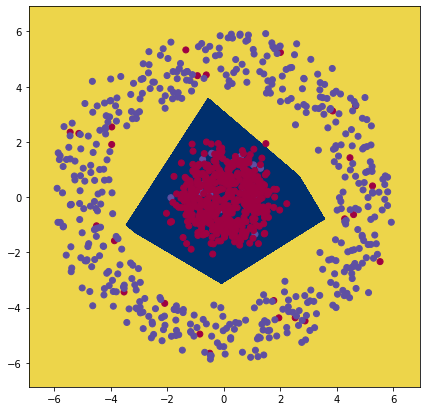

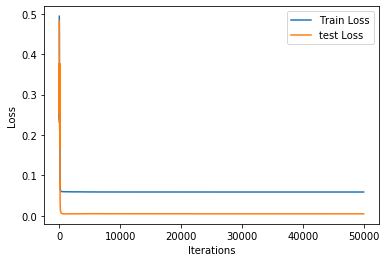

In [43]:
classes = 2
X = generateData(numExamples=1000,distributionShape='c',noise=0.05, numClasses=classes, numOutputs=1)
X_train = X[:800]
X_test = X[800:]
net = Model(numInputs=2, numOutputs=1, layerSize=5, numHiddenLayers=2, activationType='R')
net.setInput(X_train)
net.setTest(X_test)
net.initWeights(mean=1, stddev=0.1)
trainLoss, testLoss=net.train(50000, 0.001)
preds = net.predict(X_test[:,:2])
print("Score: ",precision(preds,X_test[:,2:]))
net.plotContour(X)
plotLoss(trainLoss, testLoss)

f) __[1pt]: Allow the various possible activation types.__ 
>net = Model(2,1,2,2,’S’) #same as above but with sigmoid hidden units



Iteration #:0 || Train loss: 0.462, Test loss:0.479
Iteration #:1000 || Train loss: 0.231, Test loss:0.217
Iteration #:2000 || Train loss: 0.216, Test loss:0.193
Iteration #:3000 || Train loss: 0.213, Test loss:0.186
Iteration #:4000 || Train loss: 0.207, Test loss:0.18
Iteration #:5000 || Train loss: 0.149, Test loss:0.105
Iteration #:6000 || Train loss: 0.135, Test loss:0.082
Iteration #:7000 || Train loss: 0.133, Test loss:0.083
Iteration #:8000 || Train loss: 0.132, Test loss:0.089
Iteration #:9000 || Train loss: 0.068, Test loss:0.025
Iteration #:10000 || Train loss: 0.061, Test loss:0.011
Iteration #:11000 || Train loss: 0.06, Test loss:0.008
Iteration #:12000 || Train loss: 0.059, Test loss:0.007
Iteration #:13000 || Train loss: 0.059, Test loss:0.006
Iteration #:14000 || Train loss: 0.059, Test loss:0.006
Iteration #:15000 || Train loss: 0.059, Test loss:0.006
Iteration #:16000 || Train loss: 0.059, Test loss:0.006
Iteration #:17000 || Train loss: 0.059, Test loss:0.005
Iterati

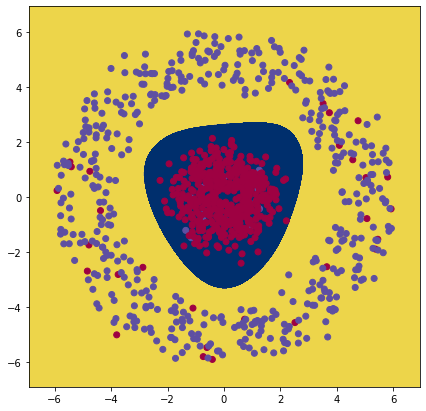

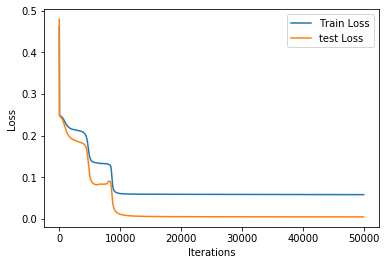

In [46]:
classes = 2
X = generateData(numExamples=1000,distributionShape='c',noise=0.05, numClasses=classes, numOutputs=1)
X_train = X[:800]
X_test = X[800:]
net = Model(numInputs=2, numOutputs=1, layerSize=4, numHiddenLayers=2, activationType='S')
net.setInput(X_train)
net.setTest(X_test)
net.initWeights(mean=1, stddev=0.1)
trainLoss, testLoss=net.train(50000, 0.001)
preds = net.predict(X_test[:,:2])
print("Score: ",precision(preds,X_test[:,2:]))
net.plotContour(X)
plotLoss(trainLoss, testLoss)

g) __[1pt]: Allow multiple output units, using SoftMax and a cross-entropy error.__ 
>net = Model(2,3,2,2,’S’) #3 SoftMax output units



Iteration #:0 || Train loss: 296.953, Test loss:41.445
Iteration #:1000 || Train loss: 215.39, Test loss:21.035
Iteration #:2000 || Train loss: 212.239, Test loss:23.534
Iteration #:3000 || Train loss: 202.024, Test loss:20.826
Iteration #:4000 || Train loss: 199.437, Test loss:20.202
Iteration #:5000 || Train loss: 191.585, Test loss:19.577
Iteration #:6000 || Train loss: 188.141, Test loss:19.16
Iteration #:7000 || Train loss: 186.241, Test loss:19.16
Iteration #:8000 || Train loss: 184.947, Test loss:19.16
Iteration #:9000 || Train loss: 183.992, Test loss:19.369
Iteration #:10000 || Train loss: 183.263, Test loss:19.785
Iteration #:11000 || Train loss: 182.697, Test loss:19.993
Iteration #:12000 || Train loss: 182.248, Test loss:19.577
Iteration #:13000 || Train loss: 181.888, Test loss:19.577
Iteration #:14000 || Train loss: 181.594, Test loss:19.16
Iteration #:15000 || Train loss: 181.352, Test loss:18.952
Iteration #:16000 || Train loss: 181.144, Test loss:19.16
Iteration #:1700

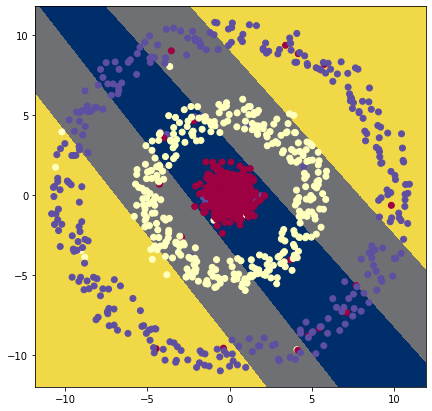

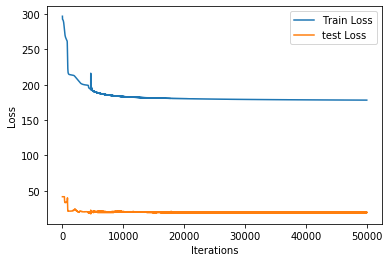

In [45]:
classes = 3
X = generateData(numExamples=1000,distributionShape='c',noise=0.05, numClasses=classes, numOutputs=1)
X_train = X[:800]
X_test = X[800:]
net = Model(numInputs=2, numOutputs=3, layerSize=2, numHiddenLayers=2, activationType='S')
net.setInput(X_train)
net.setTest(X_test)
net.initWeights(mean=1, stddev=0.1)
trainLoss, testLoss=net.train(50000, 0.001)
preds = net.predict(X_test[:,:2])
print("Score: ",precision(preds,X_test[:,2:]))
net.plotContour(X)
plotLoss(trainLoss, testLoss)

h) __[1pt]: Allow multiple hidden layers.__
>net = Model(2,1,2,5,’R’) # 5 hidden layers

Iteration #:0 || Train loss: 0.496, Test loss:0.495
Iteration #:1000 || Train loss: 0.059, Test loss:0.004
Iteration #:2000 || Train loss: 0.059, Test loss:0.004
Iteration #:3000 || Train loss: 0.059, Test loss:0.004
Iteration #:4000 || Train loss: 0.058, Test loss:0.004
Iteration #:5000 || Train loss: 0.058, Test loss:0.004
Iteration #:6000 || Train loss: 0.058, Test loss:0.003
Iteration #:7000 || Train loss: 0.058, Test loss:0.003
Iteration #:8000 || Train loss: 0.058, Test loss:0.003
Iteration #:9000 || Train loss: 0.058, Test loss:0.003
Iteration #:10000 || Train loss: 0.058, Test loss:0.004
Iteration #:11000 || Train loss: 0.058, Test loss:0.004
Iteration #:12000 || Train loss: 0.058, Test loss:0.004
Iteration #:13000 || Train loss: 0.058, Test loss:0.004
Iteration #:14000 || Train loss: 0.058, Test loss:0.004
Iteration #:15000 || Train loss: 0.058, Test loss:0.004
Iteration #:16000 || Train loss: 0.058, Test loss:0.004
Iteration #:17000 || Train loss: 0.058, Test loss:0.004
Itera

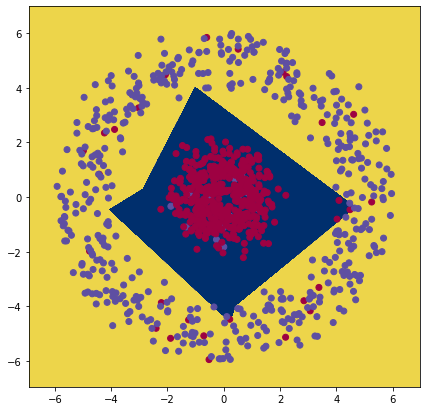

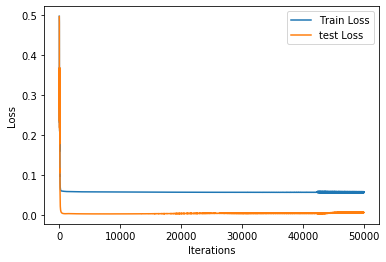

In [49]:
classes = 2
X = generateData(numExamples=1000,distributionShape='c',noise=0.05, numClasses=classes, numOutputs=1)
X_train = X[:800]
X_test = X[800:]
net = Model(numInputs=2, numOutputs=1, layerSize=5, numHiddenLayers=5, activationType='R')
net.setInput(X_train)
net.setTest(X_test)
net.initWeights(mean=1, stddev=0.1)
trainLoss, testLoss=net.train(50000, 0.001)
preds = net.predict(X_test[:,:2])
print("Score: ",precision(preds,X_test[:,2:]))
net.plotContour(X)
plotLoss(trainLoss, testLoss)

## References

[tqdm library](https://github.com/tqdm/tqdm)

[meshgrid](https://www.geeksforgeeks.org/numpy-meshgrid-function/)

[plotting contours](https://stackoverflow.com/questions/37429468/plotting-a-decision-boundary-python-give-a-good-idea-of-how-contourf-matplotli)

[Choice function](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.choice.html)

[numpy.random.uniform](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html)

[np.bincount](https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html)

[np.equal](https://docs.scipy.org/doc/numpy/reference/generated/numpy.equal.html)

[astype(int)](https://stackoverflow.com/questions/30314671/can-a-numpy-array-be-compared-to-an-integer)

[Argmax Function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html)

[Parametric equation of circle](https://www.mathopenref.com/coordparamcircle.html)

[numpy.random.normal](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html)

[numpy.random.randn](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.randn.html?highlight=numpy%20random%20randn#numpy.random.randn)

[matplotlib](https://matplotlib.org/3.1.3/tutorials/colors/colormaps.html)

[cross-entropy](https://stackoverflow.com/questions/47377222/what-is-the-problem-with-my-implementation-of-the-cross-entropy-function)